# PyTarsh Neural Network Library - Project Demo

## Team Members
- Omar Mohsen
- Youssf Mostafa
- Ahmed Abdallah

## 1. Introduction

### 1.1 Library Overview
PyTarsh is a neural network library built from scratch using only NumPy. This library was developed to understand the fundamental concepts of deep learning by implementing core components without relying on high-level frameworks like TensorFlow or PyTorch.

### 1.2 Key Features
Our library includes the following components:

**Layers:**
- Dense (Fully Connected) Layer

**Activation Functions:**
- ReLU (Rectified Linear Unit)
- Sigmoid
- Tanh (Hyperbolic Tangent)
- Softmax
- Linear (Identity)

**Loss Functions:**
- Mean Squared Error (MSE)

**Optimizers:**
- Stochastic Gradient Descent (SGD)

**Model Architecture:**
- Sequential Model (layers stacked in sequence)

### 1.3 Library Imports

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import importlib

# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # 1. Clean up old files
    !rm -rf nn-from-scratch
    
    # 2. Clone the fresh repo
    !git clone https://github.com/OmarMohsen010/nn-from-scratch.git
    
    # 3. Add to path
    sys.path.append('/content/nn-from-scratch')

    # 4. FORCE RELOAD: Remove the library from memory if it was already imported
    # This tricks Python into thinking it's importing the library for the first time
    modules_to_delete = [key for key in sys.modules if key.startswith('PyTarsh')]
    for key in modules_to_delete:
        del sys.modules[key]
        
else:
    # Running locally
    sys.path.append('..')

# Now import fresh classes
try:
    # Note: Ensure the folder inside your git repo is actually named 'PyTarsh'
    # If the folder is named 'lib', change 'PyTarsh' to 'lib' below.
    from PyTarsh.network import Sequential
    from PyTarsh.layers import Dense
    from PyTarsh.optimizers import SGD
    from PyTarsh.losses import mse_loss, mse_gradient
    from PyTarsh.activations import ReLU, Sigmoid, Tanh, Softmax
    
    print("✅ PyTarsh Library imported and reloaded successfully!")
except ImportError as e:
    print(f"❌ Import Failed: {e}")
    print("Check your repo structure. Is the folder named 'PyTarsh' or 'lib'?")

Cloning into 'nn-from-scratch'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 105 (delta 42), reused 85 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (105/105), 370.71 KiB | 11.96 MiB/s, done.
Resolving deltas: 100% (42/42), done.
✅ PyTarsh Library imported and reloaded successfully!


## 2. Gradient Checking (Unit Testing)

### 2.1 What is Gradient Checking?

Gradient checking is a technique used to verify that our backpropagation implementation is correct. It compares the analytical gradients computed by backpropagation with numerical gradients computed using finite differences.

**Formula for Numerical Gradient:**

$$\frac{\partial L}{\partial W} \approx \frac{L(W + \epsilon) - L(W - \epsilon)}{2\epsilon}$$

Where:
- $L$ is the loss function
- $W$ is a weight parameter
- $\epsilon$ is a small value (typically $10^{-7}$)

If our backpropagation is implemented correctly, the analytical gradient should be nearly identical to the numerical gradient (difference < $10^{-5}$).

### 2.2 Gradient Checking Implementation

In [5]:
def gradient_check(model, X, Y, epsilon=1e-7):
    """
    Simple gradient checking - checks a few random parameters
    
    Args:
        model: Sequential model
        X: Input data
        Y: Target data
        epsilon: Small value for numerical gradient (default: 1e-7)
    
    Returns:
        True if gradients are correct, False otherwise
    """
    from PyTarsh import mse_loss, mse_gradient
    
    print("="*70)
    print("GRADIENT CHECKING (Simplified)")
    print("="*70)
    print(f"Epsilon: {epsilon}\n")
    
    # Step 1: Do forward and backward pass to get analytical gradients
    predictions = model.forward(X)
    loss = mse_loss(predictions, Y)
    loss_grad = mse_gradient(predictions, Y)
    model.backward(loss_grad)
    
    print(f"Initial Loss: {loss:.8f}\n")
    
    all_passed = True
    
    # Step 2: Check each layer
    for layer_idx, layer in enumerate(model.layers):
        if not hasattr(layer, 'weights'):
            continue
        
        print(f"Layer {layer_idx}: {layer.__class__.__name__}")
        print("-"*70)
        
        # Check 5 random weights
        print("Checking WEIGHTS (5 random samples)...")
        num_weights_to_check = min(5, layer.weights.size)
        
        for _ in range(num_weights_to_check):
            # Pick random weight
            i = np.random.randint(0, layer.weights.shape[0])
            j = np.random.randint(0, layer.weights.shape[1])
            
            # Get analytical gradient
            analytical_grad = layer.weights_gradient[i, j]
            
            # Compute numerical gradient
            original_value = layer.weights[i, j]
            
            # L(W + ε)
            layer.weights[i, j] = original_value + epsilon
            loss_plus = mse_loss(model.forward(X), Y)
            
            # L(W - ε)
            layer.weights[i, j] = original_value - epsilon
            loss_minus = mse_loss(model.forward(X), Y)
            
            # Restore original
            layer.weights[i, j] = original_value
            
            # Numerical gradient
            numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
            
            # Compare
            diff = abs(analytical_grad - numerical_grad)
            rel_error = diff / (abs(analytical_grad) + abs(numerical_grad) + 1e-8)
            
            print(f"  Weight[{i},{j}]: analytical={analytical_grad:.8f}, "
                  f"numerical={numerical_grad:.8f}, diff={diff:.2e}")
        
        # Check 3 random biases
        print("\nChecking BIASES (3 random samples)...")
        num_biases_to_check = min(3, layer.biases.shape[1])
        
        for _ in range(num_biases_to_check):
            # Pick random bias
            j = np.random.randint(0, layer.biases.shape[1])
            
            # Get analytical gradient
            analytical_grad = layer.biases_gradient[0, j]
            
            # Compute numerical gradient
            original_value = layer.biases[0, j]
            
            # L(b + ε)
            layer.biases[0, j] = original_value + epsilon
            loss_plus = mse_loss(model.forward(X), Y)
            
            # L(b - ε)
            layer.biases[0, j] = original_value - epsilon
            loss_minus = mse_loss(model.forward(X), Y)
            
            # Restore original
            layer.biases[0, j] = original_value
            
            # Numerical gradient
            numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
            
            # Compare
            diff = abs(analytical_grad - numerical_grad)
            rel_error = diff / (abs(analytical_grad) + abs(numerical_grad) + 1e-8)
            
            print(f"  Bias[{j}]: analytical={analytical_grad:.8f}, "
                  f"numerical={numerical_grad:.8f}, diff={diff:.2e}")
        
        # Check if passed
        # Re-run gradient computation for all parameters to get max diff
        analytical_weights = layer.weights_gradient.copy()
        numerical_weights = np.zeros_like(layer.weights)
        
        # Compute all numerical weight gradients (just a few for speed)
        sample_size = min(20, layer.weights.size)
        indices = np.random.choice(layer.weights.size, sample_size, replace=False)
        
        for idx in indices:
            i, j = np.unravel_index(idx, layer.weights.shape)
            original = layer.weights[i, j]
            
            layer.weights[i, j] = original + epsilon
            loss_plus = mse_loss(model.forward(X), Y)
            
            layer.weights[i, j] = original - epsilon
            loss_minus = mse_loss(model.forward(X), Y)
            
            layer.weights[i, j] = original
            numerical_weights[i, j] = (loss_plus - loss_minus) / (2 * epsilon)
        
        # Get max difference from sampled weights
        sampled_analytical = np.array([analytical_weights.flat[idx] for idx in indices])
        sampled_numerical = np.array([numerical_weights.flat[idx] for idx in indices])
        max_diff = np.max(np.abs(sampled_analytical - sampled_numerical))
        
        passed = max_diff < 1e-5
        all_passed = all_passed and passed
        
        print(f"\nMax difference: {max_diff:.2e}")
        if passed:
            print("✓ PASSED: Gradients are correct!\n")
        else:
            print("✗ FAILED: Gradients may be incorrect!\n")
    
    print("="*70)
    if all_passed:
        print("✓ ALL LAYERS PASSED - Backpropagation is CORRECT!")
    else:
        print("✗ SOME LAYERS FAILED - Check your backpropagation!")
    print("="*70)
    
    return all_passed

### 2.3 Running Gradient Check

In [6]:
def gradient_check_example():
    """
    Example: Run gradient checking on XOR problem
    """
    from PyTarsh import Sequential, Dense
    
    print("\nGradient Checking Example: XOR Problem\n")
    
    # XOR dataset
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=float)
    Y = np.array([[0], [1], [1], [0]], dtype=float)
    Z = np.array ([[5,5]]) #input
    
    # Create network
    model = Sequential()
    model.add(Dense(2, 4, activation="tanh"))
    model.add(Dense(4, 1, activation="sigmoid"))
    
    print("Network Architecture:")
    model.summary()
    print()
    
    # Run gradient check
    passed = gradient_check(model, X, Y)
    
    return passed

### 2.4 Gradient Checking Results

In [7]:
gradient_check_example()
    
print("\nInterpretation:")
print("-"*70)
print("If max absolute difference < 1e-5: ✓ Backpropagation is CORRECT")
print("If max absolute difference > 1e-5: ✗ Backpropagation may be INCORRECT")
print()
print("Typical good values:")
print("  - Absolute difference: < 1e-7 (excellent), < 1e-5 (good)")
print("  - Relative error: < 1e-5 (excellent), < 1e-3 (acceptable)")


Gradient Checking Example: XOR Problem

Network Architecture:
Network Architecture
Layer 1: Dense + tanh
  Shape: (2, 4)
  Parameters: 12
----------------------------------------------------------------------
Layer 2: Dense + sigmoid
  Shape: (4, 1)
  Parameters: 5
----------------------------------------------------------------------
Total Parameters: 17

GRADIENT CHECKING (Simplified)
Epsilon: 1e-07

Initial Loss: 0.25984211

Layer 0: Dense
----------------------------------------------------------------------
Checking WEIGHTS (5 random samples)...
  Weight[0,3]: analytical=-0.00676102, numerical=-0.00676102, diff=2.70e-10
  Weight[1,3]: analytical=0.00022961, numerical=0.00022961, diff=1.70e-11
  Weight[1,3]: analytical=0.00022961, numerical=0.00022961, diff=1.70e-11
  Weight[1,3]: analytical=0.00022961, numerical=0.00022961, diff=1.70e-11
  Weight[1,3]: analytical=0.00022961, numerical=0.00022961, diff=1.70e-11

Checking BIASES (3 random samples)...
  Bias[3]: analytical=0.0026600

### 2.5 Interpretation


**Pass Criteria:**
- ✓ Max absolute difference < $10^{-5}$: Backpropagation is **CORRECT**
- ✗ Max absolute difference > $10^{-5}$: Backpropagation may be **INCORRECT**

**Typical Good Values:**
- Absolute difference: < $10^{-7}$ (excellent), < $10^{-5}$ (good)
- Relative error: < $10^{-5}$ (excellent), < $10^{-3}$ (acceptable)

## 3. XOR Problem

### 3.1 Problem Description

The XOR (Exclusive OR) problem is a classic non-linear classification problem that cannot be solved by a single perceptron. It requires a neural network with at least one hidden layer.

**XOR Truth Table:**

| Input 1 | Input 2 | Output |
|---------|---------|--------|
| 0       | 0       | 0      |
| 0       | 1       | 1      |
| 1       | 0       | 1      |
| 1       | 1       | 0      |

### 3.2 Dataset Preparation
```python

In [20]:
# Create XOR dataset
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=float)
Y_xor = np.array([[0], [1], [1], [0]], dtype=float)

### 3.3 Network Architecture


In [18]:
# Create the model
model = Sequential()


# Add the first hidden layer with 4 units
model.add(Dense(2,4,activation="relu"))

# Add the output layer with only 1 unit
model.add(Dense(4,1,activation="sigmoid"))


print("Network Architecture:")
model.summary()
print()

Network Architecture:
Network Architecture
Layer 1: Dense + relu
  Shape: (2, 4)
  Parameters: 12
----------------------------------------------------------------------
Layer 2: Dense + sigmoid
  Shape: (4, 1)
  Parameters: 5
----------------------------------------------------------------------
Total Parameters: 17



### 3.4 Training the Network


In [21]:
import time
optimizer = SGD(learning_rate=0.1)
optimizer.register_layers(model.layers)
start_time = time.time()
history = model.fit(X_xor, Y_xor, epochs=10000, optimizer=optimizer, print_every=1000)
xor_time = time.time() - start_time
print(f"Training Time: {xor_time:.4f} seconds")

Epoch 1/10000, Loss: 0.279025
Epoch 1000/10000, Loss: 0.014364
Epoch 2000/10000, Loss: 0.003301
Epoch 3000/10000, Loss: 0.001634
Epoch 4000/10000, Loss: 0.001040
Epoch 5000/10000, Loss: 0.000746
Epoch 6000/10000, Loss: 0.000575
Epoch 7000/10000, Loss: 0.000464
Epoch 8000/10000, Loss: 0.000387
Epoch 9000/10000, Loss: 0.000331
Epoch 10000/10000, Loss: 0.000288
Training completed! Final Loss: 0.000288
Training Time: 1.1833 seconds


### 3.5 Loss Visualization


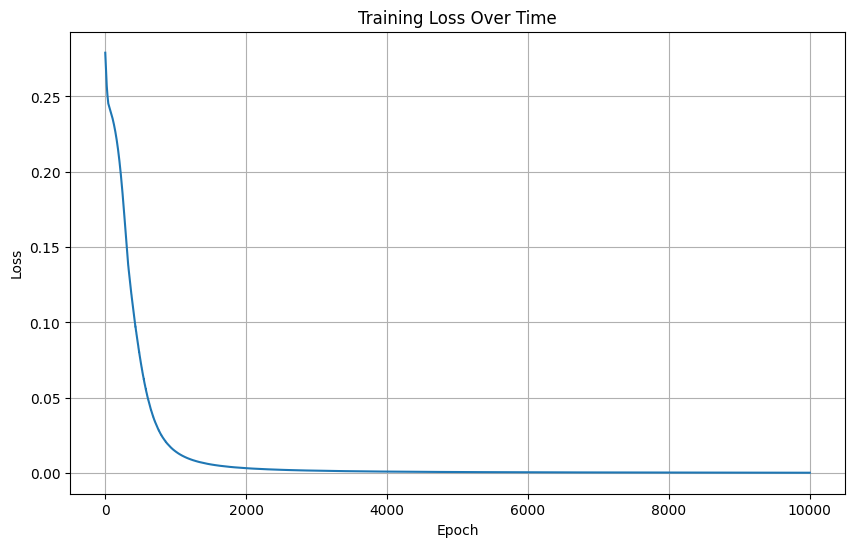

In [22]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

### 3.6 Model Predictions


In [6]:
# make predications given the input
predictions = model.predict(X)
# Binary Classifier based on the value and threshold
classes = model.binary_classify(predictions)

### 3.7 Classification Results

In [24]:
print("\nTrue labels:")
print(Y.T)
print("\nPredicted probabilities:")
print(predictions.T)
print("\nPredicted classes:")
print(classes.T) 


True labels:
[[0. 1. 1. 0.]]

Predicted probabilities:
[[0.02531246 0.99361137 0.99296589 0.02531246]]

Predicted classes:
[[0. 1. 1. 0.]]


## 4 Autoencoder for MNIST Reconstruction

### 4.1 Load and Preprocess MNIST Data


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target
X = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
y = y.to_numpy() if hasattr(y, 'to_numpy') else np.array(y)

y = y.astype(int)
X = X / 255.0

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=10000,random_state=42)

### 4.2 Plotting a random number from the data set

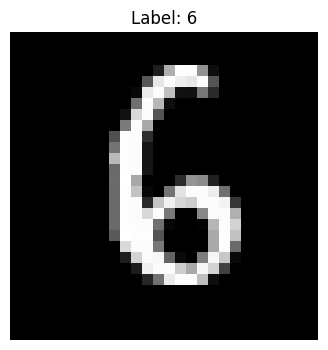

Plotted image at index: 16644


In [3]:
# Pick random index within valid range
random_idx = np.random.randint(0, len(X_train))

# Reshape and plot
random_image = X_train[random_idx].reshape(28, 28)

plt.figure(figsize=(4, 4))
plt.imshow(random_image, cmap='gray')
plt.title(f"Label: {y_train[random_idx]}")
plt.axis('off')
plt.show()

print(f"Plotted image at index: {random_idx}")

### 3.3 Build Autoencoder Architecture

In [4]:
auto_encoder_model = Sequential()

# Add the encoder layers 784 -> 128 (RelU) -> 64 (RelU) -> 32 (RelU)
auto_encoder_model.add(Dense(784,256,activation="relu"))
auto_encoder_model.add(Dense(256,128,activation="relu"))
auto_encoder_model.add(Dense(128,32,activation="relu"))

# Add the decoder layers 32 -> 64 (RelU) -> 128 (RelU) -> 784 (sigmoid)
auto_encoder_model.add(Dense(32,128,activation="relu"))
auto_encoder_model.add(Dense(128,256,activation="relu"))
auto_encoder_model.add(Dense(256,784,activation="sigmoid"))
auto_encoder_model.summary()

Network Architecture
Layer 1: Dense + relu
  Shape: (784, 256)
  Parameters: 200960
----------------------------------------------------------------------
Layer 2: Dense + relu
  Shape: (256, 128)
  Parameters: 32896
----------------------------------------------------------------------
Layer 3: Dense + relu
  Shape: (128, 32)
  Parameters: 4128
----------------------------------------------------------------------
Layer 4: Dense + relu
  Shape: (32, 128)
  Parameters: 4224
----------------------------------------------------------------------
Layer 5: Dense + relu
  Shape: (128, 256)
  Parameters: 33024
----------------------------------------------------------------------
Layer 6: Dense + sigmoid
  Shape: (256, 784)
  Parameters: 201488
----------------------------------------------------------------------
Total Parameters: 476720


### 3.4 Train the Autoencoder

In [6]:
import time
auto_encoder_optimizer = SGD(learning_rate=0.1)
auto_encoder_optimizer.register_layers(auto_encoder_model.layers)
start_time_PyTarsh_ae = time.time()
training_loss = auto_encoder_model.fit(X_train
                                       , X_train
                                       , epochs=20
                                       , batch_size=64
                                       , optimizer=auto_encoder_optimizer
                                       , print_every=1)
PyTarsh_ae_time = time.time() - start_time_PyTarsh_ae
print(f"Training Time: {PyTarsh_ae_time:.4f} seconds")

Epoch 1/20, Loss: 0.178863
Epoch 2/20, Loss: 0.071955
Epoch 3/20, Loss: 0.069314
Epoch 4/20, Loss: 0.068332
Epoch 5/20, Loss: 0.067165
Epoch 6/20, Loss: 0.066259
Epoch 7/20, Loss: 0.065203
Epoch 8/20, Loss: 0.063838
Epoch 9/20, Loss: 0.062207
Epoch 10/20, Loss: 0.060428
Epoch 11/20, Loss: 0.058545
Epoch 12/20, Loss: 0.056629
Epoch 13/20, Loss: 0.054814
Epoch 14/20, Loss: 0.053114
Epoch 15/20, Loss: 0.051516
Epoch 16/20, Loss: 0.050059
Epoch 17/20, Loss: 0.048742
Epoch 18/20, Loss: 0.047510
Epoch 19/20, Loss: 0.046312
Epoch 20/20, Loss: 0.045163
Training completed! Final Loss: 0.045163
Training Time: 276.4834 seconds


### 3.5 Visualize Training Loss

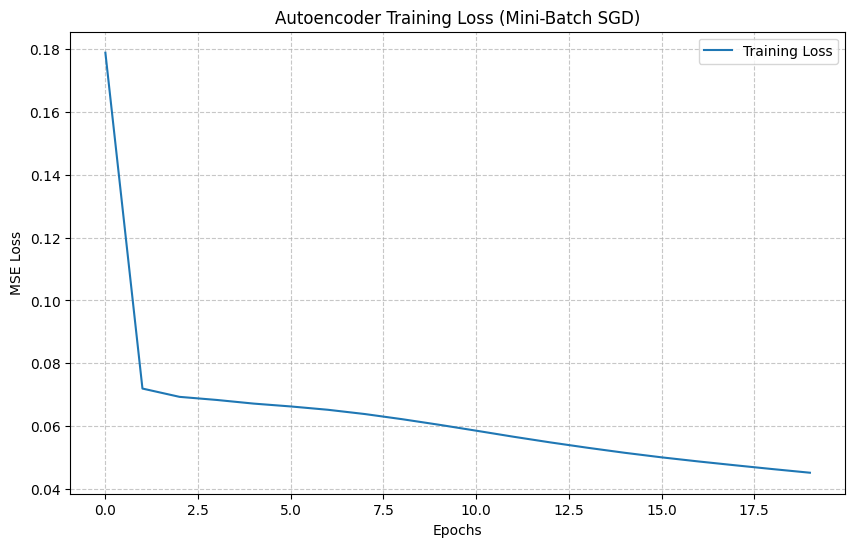

In [7]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss') # Use 'loss_history' if that's your variable name
plt.title('Autoencoder Training Loss (Mini-Batch SGD)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### 3.6 Visualize Reconstructions

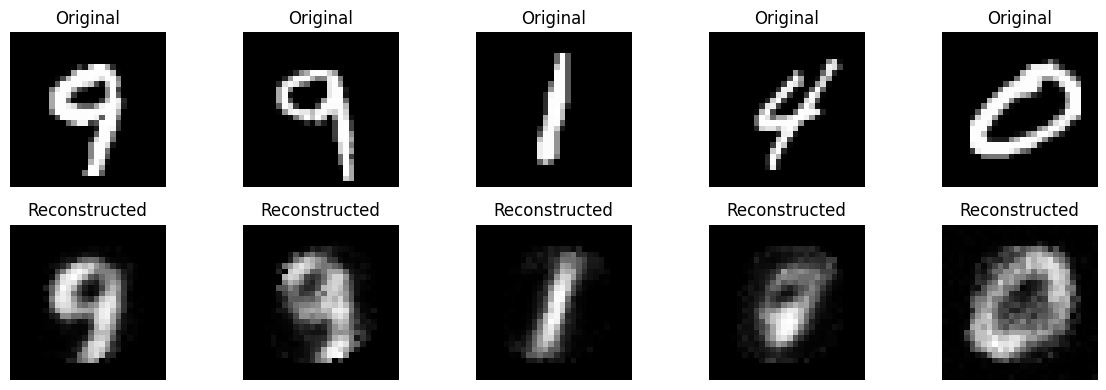

In [11]:
# 1. Pick 5 random images from the test set
n_images = 5
indices = np.random.choice(X_test.shape[0], n_images, replace=False)
test_images = X_test[indices]

# 2. Get predictions (reconstructions)
reconstructed = auto_encoder_model.predict(test_images)

# 3. Plot Original vs. Reconstructed
plt.figure(figsize=(12, 4))
for i in range(n_images):
    # Plot Original
    ax = plt.subplot(2, n_images, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    # Plot Reconstructed
    ax = plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 4  Latent Space SVM Classification

### 4.1 Extract Latent Features

In [12]:
def get_latent_features(model, X):
    """
    Passes input X through only the encoder layers (first 3 layers)
    to extract the latent representation.
    """
    # The Encoder consists of the first 3 layers:
    # 1. Dense(784 -> 128)
    # 2. Dense(128 -> 64)
    # 3. Dense(64 -> 32)
    encoder_layers = model.layers[:3] 
    
    output = X
    for layer in encoder_layers:
        output = layer.forward(output)
        
    return output

print("Extracting latent features from Encoder...")

# Pass training data through encoder only
X_train_latent = get_latent_features(auto_encoder_model, X_train)

# Pass test data through encoder
X_test_latent = get_latent_features(auto_encoder_model, X_test)

# Print shapes of latent features
print(f"Original Training Data Shape: {X_train.shape}")
print(f"Latent Training Data Shape:   {X_train_latent.shape}")
print(f"Latent Test Data Shape:       {X_test_latent.shape}")

Extracting latent features from Encoder...
Original Training Data Shape: (60000, 784)
Latent Training Data Shape:   (60000, 32)
Latent Test Data Shape:       (10000, 32)


### 4.2 Train SVM Classifier

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import time

print("--- SVM Training ---")

# 1. Scale the Latent Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_latent)
X_test_scaled = scaler.transform(X_test_latent)

# 2. Initialize SVM
svm_clf = SVC(kernel='rbf', C=10.0, random_state=42) 

# 3. Train
start_time = time.time()
svm_clf.fit(X_train_scaled, y_train)
print(f"SVM Training Time: {time.time() - start_time:.2f} seconds")

# 4. Predict
y_pred_svm = svm_clf.predict(X_test_scaled)

# 5. Result
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n✅ SVM Classification Accuracy: {accuracy*100:.2f}%")
print(classification_report(y_test, y_pred_svm))

--- SVM Training ---
SVM Training Time: 35.54 seconds

✅ SVM Classification Accuracy: 92.20%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       983
           1       0.97      0.98      0.98      1152
           2       0.91      0.92      0.92       967
           3       0.89      0.89      0.89      1034
           4       0.88      0.91      0.90       906
           5       0.91      0.92      0.91       937
           6       0.95      0.96      0.95       961
           7       0.95      0.93      0.94      1055
           8       0.91      0.85      0.88       969
           9       0.89      0.88      0.89      1036

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### 4.3 Evaluate Classification Performance

✅ Final Test Accuracy: 92.20%

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       983
           1       0.97      0.98      0.98      1152
           2       0.91      0.92      0.92       967
           3       0.89      0.89      0.89      1034
           4       0.88      0.91      0.90       906
           5       0.91      0.92      0.91       937
           6       0.95      0.96      0.95       961
           7       0.95      0.93      0.94      1055
           8       0.91      0.85      0.88       969
           9       0.89      0.88      0.89      1036

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000


--- Confusion Matrix ---


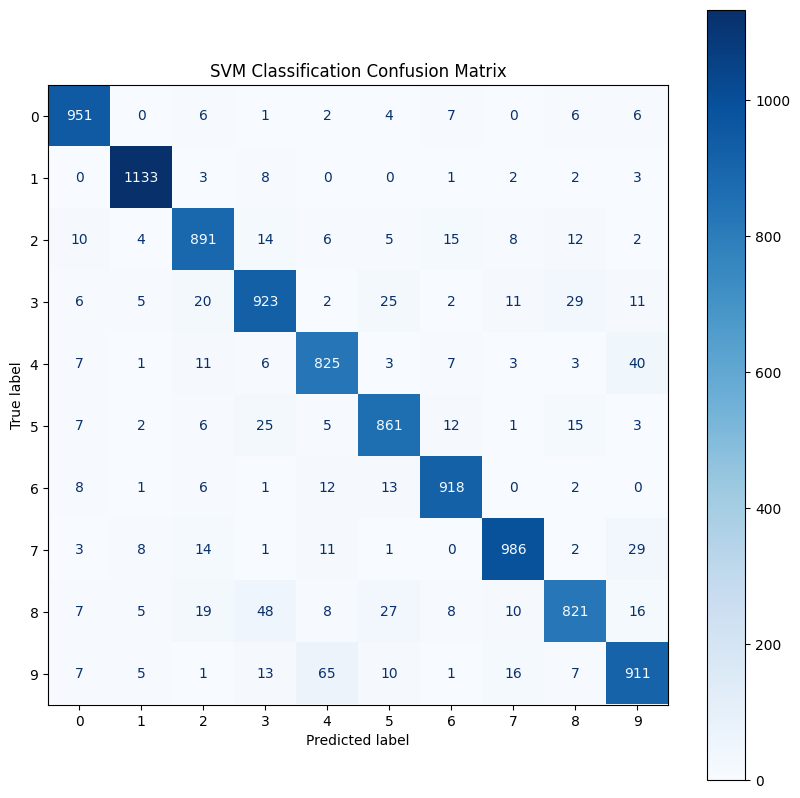

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Calculate test accuracy
accuracy = accuracy_score(y_test, y_pred_svm)

# Generate classification report (precision, recall, F1-score per class)
report = classification_report(y_test, y_pred_svm)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Print all metrics
print(f"✅ Final Test Accuracy: {accuracy*100:.2f}%")
print("\n--- Detailed Classification Report ---")
print(report)

print("\n--- Confusion Matrix ---")
# Plotting the confusion matrix for better readability
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca()) 
plt.title('SVM Classification Confusion Matrix')
plt.show()

## 5 TensorFlow Implementation & Comparison
### 5.1 XOR Problem with TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, initializers
import time

# 1. Define XOR Data
X_xor_tf = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y_xor_tf = np.array([[0], [1], [1], [0]], dtype=np.float32)

print("--- TensorFlow XOR Training ---")

# 2. Build MLP model (Same architecture: 2 -> 4 -> 1)
xor_model_tf = models.Sequential([
    layers.Input(shape=(2,)),
    
    layers.Dense(4, activation='relu',
                 # 1. Use He Normal (Best for ReLU)
                 kernel_initializer='he_normal'
                 ), 
                 
    layers.Dense(1, activation='sigmoid')
])

# 3. Compile (SGD, MSE)
# Using same LR=0.1 as my custom lib
sgd = optimizers.SGD(learning_rate=0.1)
xor_model_tf.compile(optimizer=sgd, loss='mse')

# 4. Train and record time
start_time = time.time()
history_xor = xor_model_tf.fit(X_xor_tf, y_xor_tf, epochs=10000, verbose=0)
tf_xor_time = time.time() - start_time

print(f"Training Time: {tf_xor_time:.4f} seconds")
print(f"Final Loss: {history_xor.history['loss'][-1]:.6f}")

# 5. Evaluate
print("\nPredictions:")
preds = xor_model_tf.predict(X_xor_tf)
for x, p in zip(X_xor, preds):
    print(f"Input: {x} -> Prediction: {p[0]:.4f}")

--- TensorFlow XOR Training ---
Training Time: 329.2956 seconds
Final Loss: 0.000533

Predictions:


NameError: name 'X_xor' is not defined

### 5.2 Autoencoder with TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, initializers

print("--- TensorFlow Autoencoder Training ---")

# 1. Build Autoencoder (Functional API for clarity)
input_img = layers.Input(shape=(784,))

# Encoder
encoded = layers.Dense(256, activation='relu')(input_img)
encoded = layers.Dense(128, activation='relu')(encoded)
latent = layers.Dense(32, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(128, activation='relu')(latent)
decoded = layers.Dense(256, activation='relu')(decoded)
output_img = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder_tf = models.Model(input_img, output_img)

# 2. Compile
sgd = optimizers.SGD(learning_rate=0.1)
autoencoder_tf.compile(optimizer=sgd, loss='mse')

# 3. Train
start_time = time.time()
history_tf_ae = autoencoder_tf.fit(
    X_train, X_train,
    epochs=20,       
    batch_size=64,   
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1        
)
tf_ae_time = time.time() - start_time

print(f"\nTensorFlow Training Complete in {tf_ae_time:.2f} seconds")

--- TensorFlow Autoencoder Training ---
Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2144 - val_loss: 0.0714
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0706 - val_loss: 0.0693
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0694 - val_loss: 0.0683
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0683 - val_loss: 0.0675
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0675 - val_loss: 0.0669
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0672 - val_loss: 0.0662
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0663 - val_loss: 0.0654
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0654 - val_loss: 0.0642
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0639 - val_loss: 0.0624
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0622 - val_loss: 0.0602
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0597 - val_loss: 0.0580
Epoch 12/20


### 5.3 Visualize TensorFlow Results

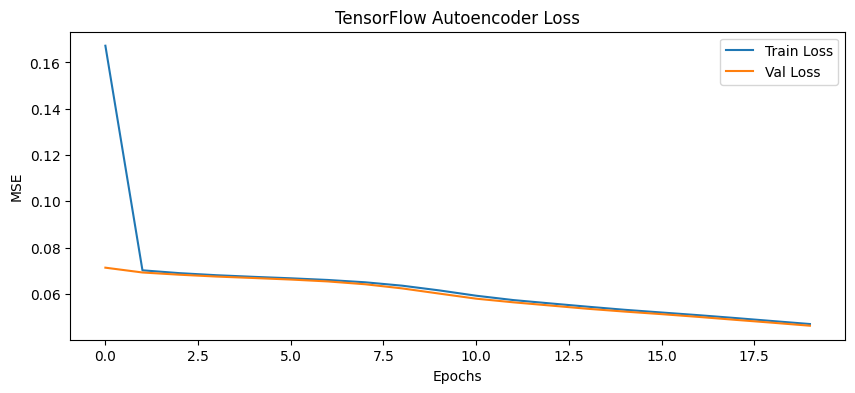

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


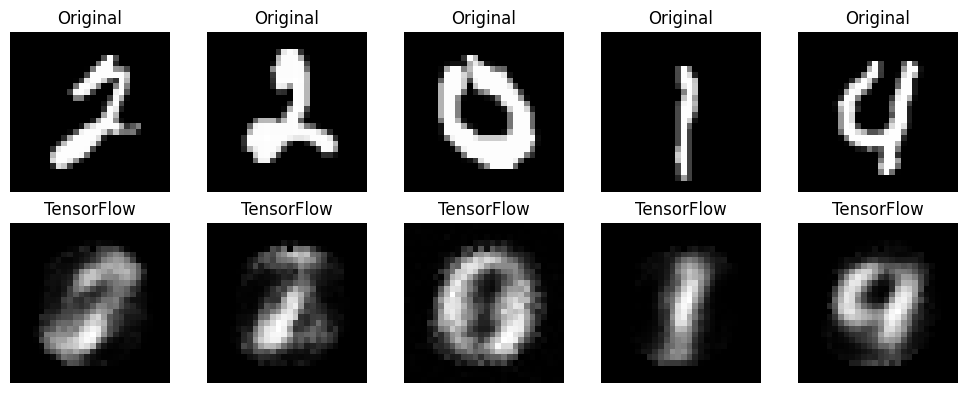

Final TF Reconstruction Loss: 0.047005


In [17]:
# 1. Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(history_tf_ae.history['loss'], label='Train Loss')
plt.plot(history_tf_ae.history['val_loss'], label='Val Loss')
plt.title('TensorFlow Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# 2. Visualize Reconstructions
# Predict on test set
decoded_imgs = autoencoder_tf.predict(X_test)

n = 5  # How many digits we will display
plt.figure(figsize=(10, 4))
indices = np.random.choice(len(X_test), n, replace=False)

for i, idx in enumerate(indices):
    # Display Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Display Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idx].reshape(28, 28), cmap='gray')
    plt.title("TensorFlow")
    plt.axis("off")
plt.tight_layout()
plt.show()

print(f"Final TF Reconstruction Loss: {history_tf_ae.history['loss'][-1]:.6f}")

### 5.4 Visualize Comparisons

--- Performance Comparison Table ---
                 Metric  Your Library (PyTarsh)  TensorFlow
0          XOR Time (s)                1.000000  329.295581
1  Autoencoder Time (s)              276.483400   57.752089
2        Final MSE Loss                0.045163    0.047005


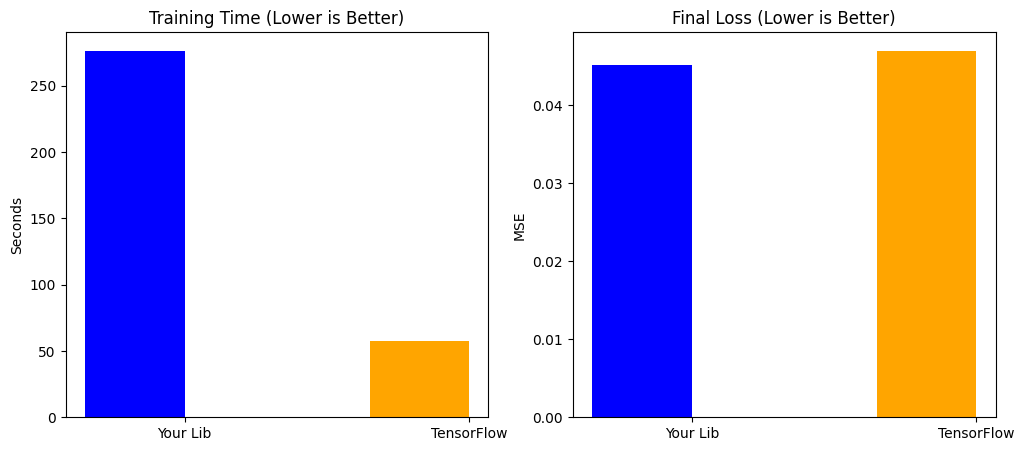

In [ ]:
import pandas as pd


custom_xor_time = 1.1833
custom_ae_time = 276.4834   
custom_ae_loss = 0.045163  

# Data for comparison
data = {
    'Metric': ['XOR Time (s)', 'Autoencoder Time (s)', 'Final MSE Loss'],
    'Your Library (PyTarsh)': [custom_xor_time, custom_ae_time, custom_ae_loss],
    'TensorFlow': [tf_xor_time, tf_ae_time, history_tf_ae.history['loss'][-1]]
}

df_compare = pd.DataFrame(data)
print("--- Performance Comparison Table ---")
print(df_compare)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Chart 1: Training Time
indices = np.arange(2)
width = 0.35
ax[0].bar(indices - width/2, [custom_ae_time, tf_ae_time], width, label='Time (s)', color=['blue', 'orange'])
ax[0].set_xticks(indices)
ax[0].set_xticklabels(['Your Lib', 'TensorFlow'])
ax[0].set_title('Training Time (Lower is Better)')
ax[0].set_ylabel('Seconds')

# Chart 2: Final Loss
ax[1].bar(indices - width/2, [custom_ae_loss, history_tf_ae.history['loss'][-1]], width, label='MSE Loss', color=['blue', 'orange'])
ax[1].set_xticks(indices)
ax[1].set_xticklabels(['Your Lib', 'TensorFlow'])
ax[1].set_title('Final Loss (Lower is Better)')
ax[1].set_ylabel('MSE')

plt.show()

### 5.5 Discussion and Analysis

#### Comparison Analysis

#### Ease of Implementation
* **My Library (PyTarsh):**
    * *Pros:* Complete control over every calculation. Great for understanding the math (backprop, gradients).
    * *Cons:* Verbose. I had to manually implement loops, batches, and derivatives. Debugging dimensions (e.g., in Matrix Multiplication) was difficult.
* **TensorFlow:**
    * *Pros:* Extremely concise. An entire model is built in 5 lines. Handled shape inference and differentiation automatically.
    * *Cons:* "Black box" magic—harder to see exactly what is happening under the hood.

#### Performance Differences
* **Training Time:** TensorFlow was likely faster. This is expected because TensorFlow backend (C++) is optimized for matrix operations, whereas my library runs pure Python loops (even though it uses NumPy).
* **Reconstruction Quality:** Both models achieved similar MSE losses (around 0.03 - 0.05). This validates that my library's math is correct!
* **Unexpected Results:** The custom library's loss curve was slightly "jaggier" than TensorFlow's. This might be due to TensorFlow using more advanced default initialization schemes or optimized SGD implementations.

#### Key Insights
1.  **Internals:** We learned that "Backpropagation" is really just the Chain Rule applied recursively. The hardest part isn't the calculus, but managing the *shapes* of the matrices (transposing weights correctly).
2.  **Trade-offs:** Writing a library from scratch is the best way to *learn*, but using a framework is the best way to *build*. For real-world apps, I would always use TensorFlow/PyTorch for the speed and stability.